<center style="font-size: 16px; font-weight: normal">
  `21 Microservices Architecture Patterns Study</center>

<center><h1>Chapter 5. TDD in High and Low Gears</h1></center>

<center>
  Joseph Kim &lt;cloudeyes@gmail.com&gt;<br/>
  Jab 12. 2021<br/>
</center>

<center>
  <img src="https://images-na.ssl-images-amazon.com/images/I/51-q9CWNBHL._SX379_BO1,204,203,200_.jpg" style="width: 200px">
</center>

<center>
  <a href="https://github.com/cloudeyes/2021-msa-study/blob/main/05-tdd-in-high-and-low-gears/05-tdd-in-high-and-low-gears.ipynb">Download Jupyter Notebook</a>
</center>

# 05. TDD in High and Low Gears

## Introduction

### TDD Terms

#### Test Pyramid
- The "Test Pyramid" is a metaphor that tells us to group software tests into buckets of different granularity. It also gives an idea of how many tests we should have in each of these groups. Although the concept of the Test Pyramid has been around for a while, teams still struggle to put it into practice properly. 

*See also*:

- [The Practical Test Pyramid by Ham Vocke](https://martinfowler.com/articles/practical-test-pyramid.html)
- [Why the test pyramid is a bullsh*t — guide to testing towards modern frontend and backend apps](https://medium.com/@mateuszroth/why-the-test-pyramid-is-a-bullshit-guide-to-testing-towards-modern-frontend-and-backend-apps-4246e89b87bd)

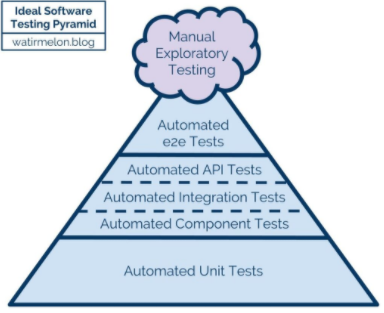 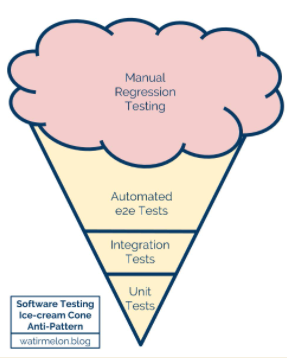

#### Test Double

Stunt Double(스턴트 대역) 에서 유래된 말입니다. 테스트를 대신해주는 "대역"을 뜻합니다.

Test double is a generic term for any case where you replace a production object for testing purposes. There are various kinds of double that Gerard lists, such as:

- **Dummy** objects are passed around but never actually used. Usually they are just used to fill parameter lists.
- **Fake** objects actually have working implementations, but usually take some shortcut which makes them not suitable for production (an InMemoryTestDatabase is a good example).
- **Stubs** provide canned answers to calls made during the test, usually not responding at all to anything outside what's programmed in for the test.
- **Spies** are stubs that also record some information based on how they were called. One form of this might be an email service that records how many messages it was sent.
- **Mocks** are pre-programmed with expectations which form a specification of the calls they are expected to receive. They can throw an exception if they receive a call they don't expect and are checked during verification to ensure they got all the calls they were expecting.

*See also*:

- [TestDouble by Martin Fowler](https://martinfowler.com/bliki/TestDouble.html)

### Difference between Various Kinds of Testing

**Unit testing** means testing individual modules of an application in isolation (without any interaction with dependencies) to confirm that the code is doing things right.

**Integration testing** means checking if different modules are working fine when combined together as a group.

**Functional testing** means testing a slice of functionality in the system (may interact with dependencies) to confirm that the code is doing the right things.

#### Integration Tests vs Functional Tests

Functional tests are related to integration tests, however, they signify to the tests that check the entire application’s functionality with all the code running together, nearly *a super integration test*.

*See also*:

  - [Unit Testing Vs Integration Testing Vs Functional Testing](https://www.softwaretestinghelp.com/the-difference-between-unit-integration-and-functional-testing/)

### Sanity Checks for the Project

In [ ]:
!git checkout tags/05-step-01 -b 05-tdd-low-and-high-gears

In [1]:
!mypy -p app --strict

Success: no issues found in 28 source files


In [2]:
!pytest app/tests

============================= test session starts ==============================
platform linux -- Python 3.9.1, pytest-6.1.2, py-1.10.0, pluggy-0.13.1
rootdir: /home/ykkim/notebooks/2021-msa-study/05-tdd-in-high-and-low-gears
plugins: flask-1.1.0, anyio-2.0.2
collected 25 items                                                             

app/tests/e2e/test_flask_api.py .                                        [  4%]
app/tests/integration/test_orm.py ......                                 [ 28%]
app/tests/integration/test_repository.py ..                              [ 36%]
app/tests/unit/test_allocate.py ....                                     [ 52%]
app/tests/unit/test_batch.py .........                                   [ 88%]
app/tests/unit/test_services.py ...                                      [100%]

============================== 25 passed in 0.93s ==============================


In [3]:
!pylint app


--------------------------------------------------------------------
Your code has been rated at 10.00/10 (previous run: 10.00/10, +0.00)



## How is our Test Pyramid Looking?

In [4]:
!grep -c test_ -R app/tests | grep -vE ':0|conftest|.pyc|.ipynb'

app/tests/unit/test_batch.py:9
app/tests/unit/test_allocate.py:4
app/tests/unit/test_services.py:3
app/tests/integration/test_orm.py:6
app/tests/integration/test_repository.py:2
app/tests/e2e/test_flask_api.py:1
app/tests/__init__.py:2


In [5]:
from subprocess import Popen, PIPE, STDOUT
from collections import defaultdict
proc = Popen("grep -c test_ -R app/tests | grep -vE ':0|conftest|.pyc|.ipynb'", shell=True, stdout=PIPE)
output = proc.stdout.read().decode().strip()
stats = defaultdict(lambda: 0)
for k, v in (it.split(':') for it in output.split('\n')):
    stats[k.split('/')[2]] += int(v)
dict(stats)

{'unit': 16, 'integration': 8, 'e2e': 1, '__init__.py': 2}

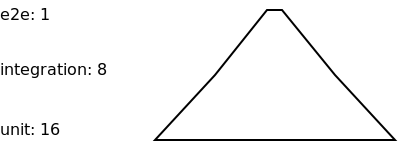

In [6]:
from app.utils import show_test_pyramid
show_test_pyramid(stats)

## Should Domain Layer Tests Move to the Service Layer?

Problems can happen from *too many* tests against their domain model.
- Sometime they *DO NOT reflect properties of a system*, but only low-level implementation of a system. 
- If we want to change *the design of our code*, any tests relying directly on the code will also fail.

따라서, 테스트를 서비스 레이어에 한정 지어서 감춰진 메소드나 속성으로부터 깨지기 쉬운 테스트를 보호하는 것이 좋습니다.

## On Deciding What Kind of Tests to Write

모든 유닛 테스트를 서비스 계층에 대해 재작성 해야 할까요? 도메인 모델에 직접 테스트 하는건 잘못된 것일까요? 이런 질문에 답하기 위해 테스트 종류에 따른 트레이드 오프(테스트 스펙트럼)를 이해해야 합니다.

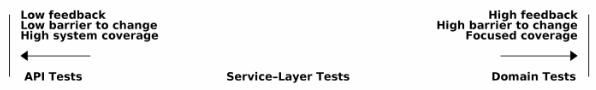

테스트의 목적은 변경에 대한 피드백을 얻기 위함입니다. 테스트가 실제 구현에 가까울 수록 더 좁은 범위(커버리지)에서 강한 피드백을 받게 됩니다. 높은 단계의 추상화에 가까울 수록 테스트는 대규모 변경에 대한 넓은 범위의 피드백을 얻게 됩니다.

서비스 계층에 대한 테스트(API 테스트)는 특정 구현에 종속되지 않은 시스템의 특성을 체크하고 대규모 변경에 대한 자신감을 얻기 위해 사용합니다.     

특히 도메인 테스트에 대한 피드백은 시스템 세부사항에 대한 즉각적이고 강력한 피드백을 주어 시스템을 이해하는데 큰 도움을 줍니다. 즉, 도메인 테스트는 도메인 언어로 쓰여진 일종의 "살아있는 문서" 역할을 합니다.

신규 프로젝트를 수행하여 아직 도메인에 대해서 잘 알지 못할 경우 "도메인 모델에 대한 테스트"는 시스템의 이해를 돕고 실제 코드를 어덯게 작성할지 감을 찾는데 매우 효과적입니다. 

한편 도메인에 대한 이해가 충분히 되고, 설계 개선이 필요하다고 판단되면 세부 구현에 종속된 이런 테스트들을 API 레벨로 교체할 필요가 있습니다.

## High Gear(저속 기어) and Low Gear(고속 기어)

기존 기능을 확장하거나 버그 수정을 할 경우, 도메인 모델의 수정이 거의 필요하지 않다면 효과적으로 달리기 위해 고속 기어(서비스 레벨 테스트)를 놓고 달립니다.

하지만 처음 프로젝트를 시작해서 도메인을 잘 모르거나, 중요하고 어려운 작업을 신중하게 수행해야 할 경우 저속 기어(도메인 레벨 테스트)로 전환하여 어려움을 극복할 수 있습니다.

## Fully Decoupling the Service-Layer Tests from the Domain

### Mitigation: Keep All Domain Dependencies in Fixture Functions

### Adding a Missing Service

## Carrying the Improvment Through to the E2E Tests

## Wrap-Up

In [8]:
!jupyter nbconvert 05-tdd-in-high-and-low-gears.ipynb --output-dir=./exports --to html \
  --TagRemovePreprocessor.remove_input_tags='{"hidden-input"}' \
  --TagRemovePreprocessor.remove_all_outputs_tags='{"hidden-output"}' \
  --TagRemovePreprocessor.remove_cell_tags='{"hidden"}'

[NbConvertApp] Converting notebook 05-tdd-in-high-and-low-gears.ipynb to html
[NbConvertApp] Writing 591218 bytes to exports/05-tdd-in-high-and-low-gears.html
